## Time Series Forecasting using dataset "Bitcoin Historical Data"

### Problem Statement

Despite the growing adoption of Bitcoin and other cryptocurrencies, accurately forecasting their prices remains a significant challenge due to the high volatility, non‑stationarity, and complex temporal dynamics inherent in high‑frequency financial time series data. Traditional statistical forecasting models often struggle to capture nonlinear price behavior, while machine learning approaches, though powerful, are frequently applied without systematic comparison to established statistical techniques. This lack of integration and evaluation creates uncertainty regarding the most effective modeling approach for predicting Bitcoin price movements. Consequently, there is insufficient empirical evidence to guide the selection of appropriate methods for Bitcoin price forecasting. To address this gap, the present study undertakes a systematic comparative analysis of statistical and machine learning models, applied to historical high‑frequency Bitcoin closing price data, with the aim of evaluating their ability to capture trends and volatility in cryptocurrency markets.

### Project Rationale
The goal of this project is to develop a predictive model for Bitcoin closing prices using historical 1-minute data, comparing statistical and machine learning approaches to identify trends and volatility patterns.

### Objectives
- Analyze the temporal dynamics of Bitcoin closing prices by leveraging historical high‑frequency time series data.
- Design and implement predictive models for Bitcoin closing prices, employing both statistical techniques and machine learning approaches.
- Assess and compare the effectiveness of statistical and machine learning models in capturing price trends and volatility within Bitcoin markets.


In [1]:
# Importing necessary libraries 
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv(r"data\bitcoin_historical_data.csv")
data.tail()

,Timestamp,Open,High,Low,Close,Volume
7337913,1.765756e+09,88252.0,88252.0,88221.0,88221.0,0.478176
7337914,1.765756e+09,88238.0,88238.0,88215.0,88230.0,0.913307
7337915,1.765757e+09,88235.0,88243.0,88143.0,88143.0,1.793743
7337916,1.765757e+09,88125.0,88192.0,88125.0,88162.0,0.496879
7337917,1.765757e+09,88162.0,88164.0,88150.0,88160.0,1.075660


In [3]:
# Inspecting the data
data.info()
data.describe()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337918 entries, 0 to 7337917
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 335.9 MB


Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

The data has 7337918 rows and 5 columns. The columns include:

- `Timestamp`: The exact date and time the observation was recorded. 
-  `Open`: The first traded price of Bitcoin at that time interval. 
- `High`: The highest price Bitcoin reached during that time interval.   
- `Low`: The lowest price Bitcoin reached during that time interval. 
- `Close`: The last traded price at the end of the interval. 
- `Volume`: The amount of Bitcoin traded during the interval. 

The data has no null values and missing values. 

In [4]:
data.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [5]:
# data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
# data.set_index('Timestamp', inplace=True)

In [6]:
# Converting the timestamps into datetime format
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# data["Timestamp"]

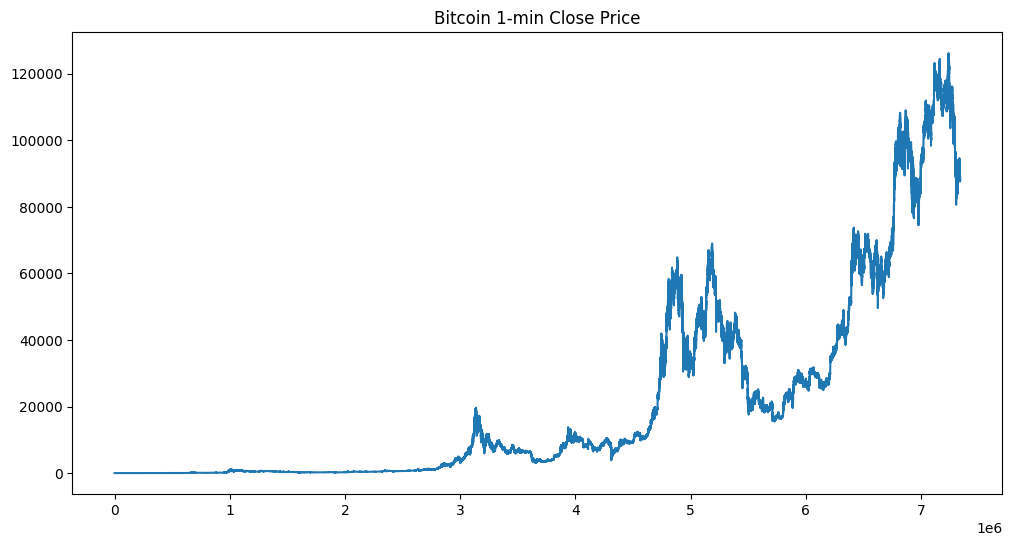

In [7]:
# Plotting the data to show the trend
plt.figure(figsize=(12, 6))
data['Close'].plot(figsize=(12,6), title="Bitcoin 1-min Close Price")
plt.show(); 

The visualization of Bitcoin’s 1-minute close price over the recorded period shows an initial phase of low, stable prices, followed by multiple sharp increases representing boom periods. The series exhibits strong upward trend, high volatility, and non-constant variance, with extreme spikes reflecting sudden market activity. Such characteristics suggest the need for resampling, trend-stationarity checks, and careful modeling in any forecasting analysis.



### Data Preparation 

In [8]:
# Converting `Timestamp` to datetime format, set as the index and confirm frequency
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data.set_index('Timestamp', inplace=True)
data = data.sort_index()

1-minute data is too noisy and would be too large for most models, so to make the data more suitable for modelling, I will be performing resampling. 

In [9]:
# Daily average closing price
daily_close = data['Close'].resample('1D').mean()

In [10]:
daily_close.nunique()


5094

In [11]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(daily_close.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -0.607003848010526
p-value: 0.8693915775633008


As the p-value is > 0.05, the data is non-stationary and therefore diffencing is needed. 

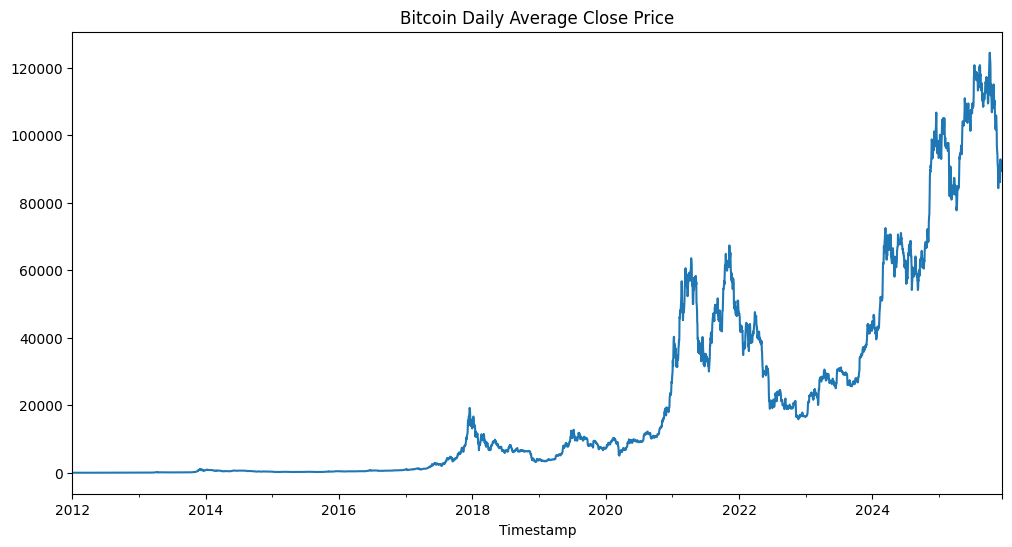

In [12]:
# Getting the sense of the daily close data
daily_close.plot(figsize=(12,6), title="Bitcoin Daily Average Close Price"); 

Visualization of Bitcoin's closing prices indicates strong non-staionary behavior, with long-term upward trends and increasing volatility over time. The sharp price spikes and sudden drops are observed, reflecting periods of intense market activity. 

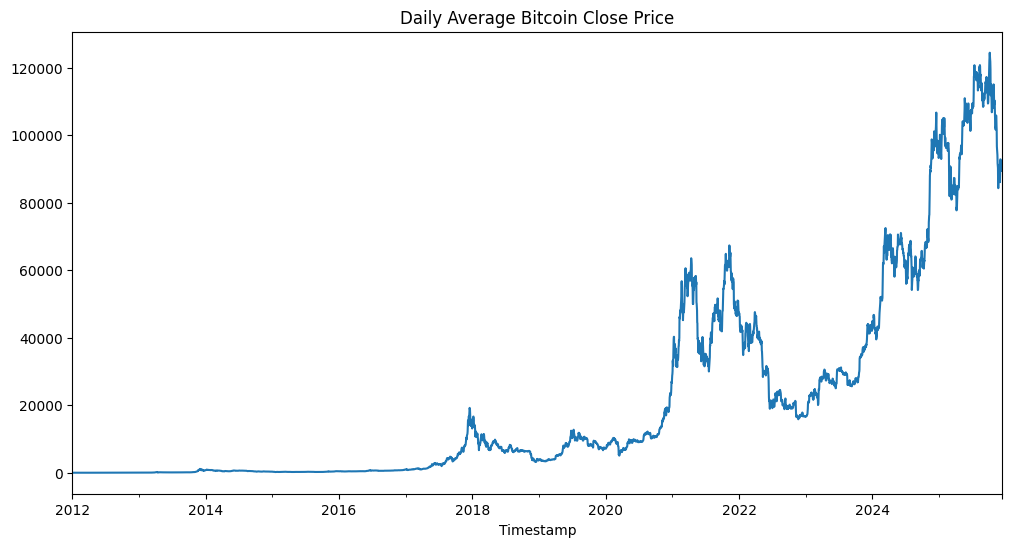

In [13]:
# Resampling for pattern discovery
daily_close = data['Close'].resample('1D').mean()
daily_close.plot(title="Daily Average Bitcoin Close Price")
plt.show(); 

Resampling the data to daily frequency reduces high-frequency noise and reveals clearer long-term trends, making temporal patterns more interpretable for modeling.

### Objective 1: Analyze the temporal dynamics of Bitcoin closing prices by leveraging historical high‑frequency time series data. 

The aim of the the porject is to be able to show: 
- how Bitcoin prices behave over time, 
- whether prices show trends, 
- how volatile the market is, 
- whether the data is stationary or not, 
- how time resolution affects the patterns,  

### Understanding the time structure of the data

In [14]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [15]:
# Observing the timestamps
print(data.index)

DatetimeIndex(['2012-01-01 10:01:00', '2012-01-01 10:02:00',
               '2012-01-01 10:03:00', '2012-01-01 10:04:00',
               '2012-01-01 10:05:00', '2012-01-01 10:06:00',
               '2012-01-01 10:07:00', '2012-01-01 10:08:00',
               '2012-01-01 10:09:00', '2012-01-01 10:10:00',
               ...
               '2025-12-14 23:49:00', '2025-12-14 23:50:00',
               '2025-12-14 23:51:00', '2025-12-14 23:52:00',
               '2025-12-14 23:53:00', '2025-12-14 23:54:00',
               '2025-12-14 23:55:00', '2025-12-14 23:56:00',
               '2025-12-14 23:57:00', '2025-12-14 23:58:00'],
              dtype='datetime64[ns]', name='Timestamp', length=7337918, freq=None)


The timestamps are continuous, recorded at one minute intervals with no missing observations. The dataset is structured as both univariate and multivariate time series, making it well-suited for high-frequency temporal analysis. 

### Exploring the closing price over time

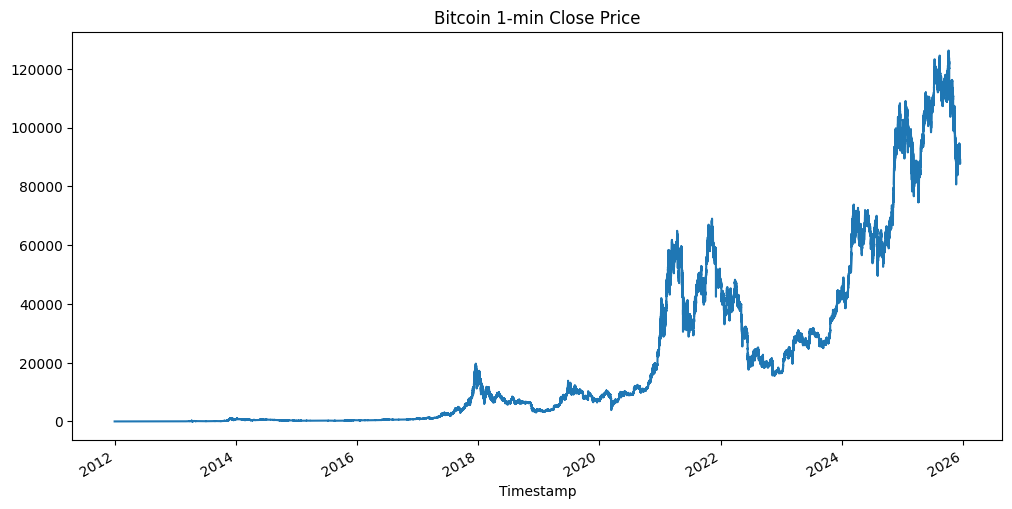

In [16]:
data["Close"].plot(figsize=(12, 6), title="Bitcoin 1-min Close Price")
plt.show(); 

The Bitcoin closing prices show clear time-based patterns, with sharp swings and high volatility that highlight the speculative nature of cryptocurrency markets. 

### Analyse price volatility (OHLC Analysis)

In [18]:
!pip install mplfinance

To be able to visualize the OHLC, I used a Python library that specializes in visualizing finnacial market data including OHLC and other price-movement charts. 

c:\Users\User\anaconda3\envs\myvenv\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


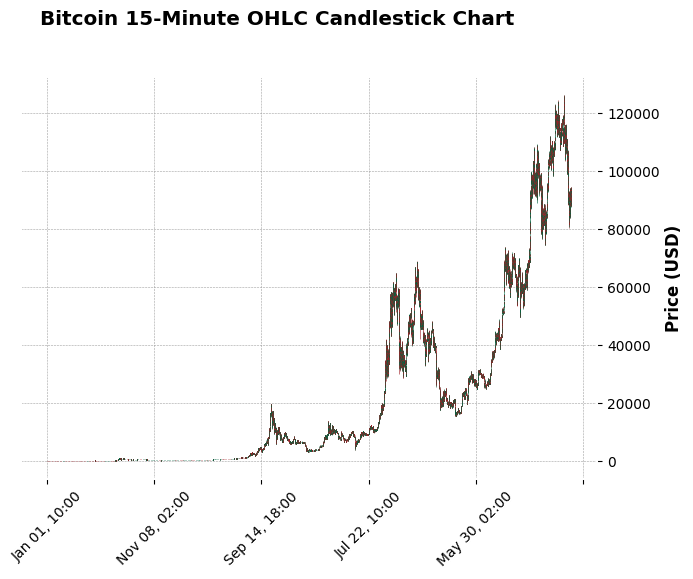

In [ ]:
# Understanding intraperiod price movements (15 minutes)

import mplfinance as mpf

ohlc_data = data[['Open', 'High', 'Low', 'Close']].copy()

ohlc_15min = ohlc_data.resample('15min').agg({'Open': 'first', 
                                               'High': 'max',
                                               'Low': 'min',
                                               'Close': 'last'})

mpf.plot(
    ohlc_15min,
    type='candle',
    style='charles',
    title='Bitcoin 15-Minute OHLC Candlestick Chart',
    ylabel='Price (USD)',
    volume=False
)


The OHLC chart above was used to visualize intraperiod price movements. The cahrt reveals substantial volatility, with frequent large price renages, highlighting rapid market flucruations characteristic of cryprocurrency trading. 

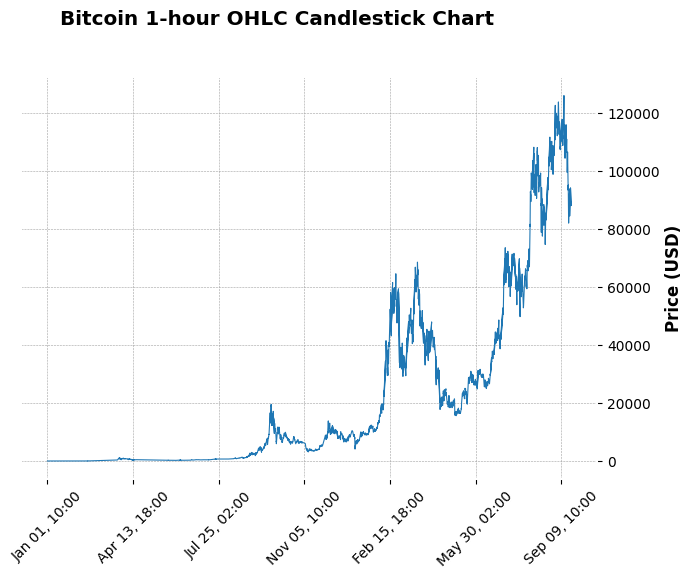

In [23]:
# Understanding intraperiod price movements (1 hour) using a line plot

import mplfinance as mpf

ohlc_data = data[['Open', 'High', 'Low', 'Close']].copy()

ohlc_1h = ohlc_data.resample('1h').agg({'Open': 'first', 
                                               'High': 'max',
                                               'Low': 'min',
                                               'Close': 'last'})

mpf.plot(
    ohlc_1h,
    type='line',
    style='charles',
    title='Bitcoin 1-hour OHLC Candlestick Chart',
    ylabel='Price (USD)',
    volume=False
)


In [ ]:
The Bitcoin 1-hour OHLC chart displays price movements over time using hourly intervals, where each candlestick represents the open, high, low and close prices within a single hour. Spanning from January 1 to September 9, the chart reveals sharp fluctuations and pronounced volatility, with notable peaks around mid-February and early September. This highlighted the speculative nature of cryptocurrency markets. The high-frequency visualization captures the temporal dependencies and nonlinear dynamics of Bitcoin prices, making it a valuable tool for analyzing trends and testing predictive models across different time horizons. 

### UNderstanding market activity over time

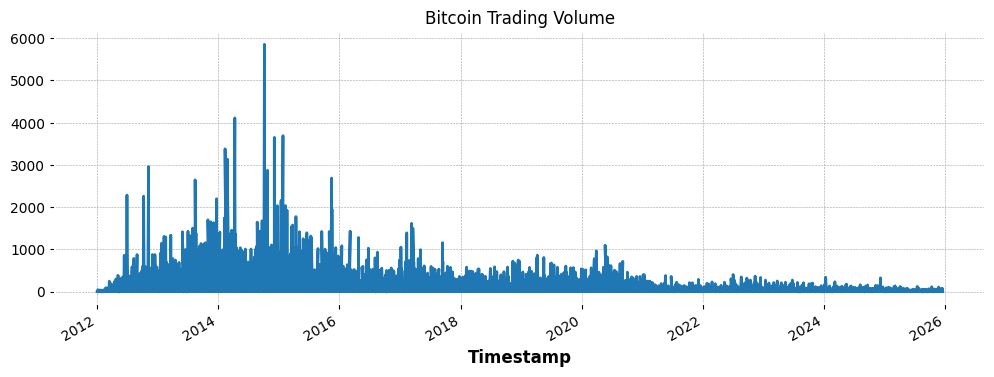

In [25]:
data['Volume'].plot(figsize=(12,4), title="Bitcoin Trading Volume")
plt.show(); 

The trading volume displays irregular spikes that may be coinciding with significant price changes, suggesting a relationship between market participation and price volatility. 

### Objective 2: Design and implement predictive models for Bitcoin closing prices, employing both statistical techniques and machine learning approaches.

The forecasting task is defines as predicting the next time-step Bitcoin closing price based on historical observation. The predicting feature would be `Close`, and the freqeuncy will be hourly and not by the minute. 

In [28]:
# Resampling the data to hourly frequency
hourly_close = data['Close'].resample('1h').mean()  

In [29]:
# Resampling and finalising modelling frequency
daily = data.resample("1D").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
})
daily.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742


The need for resampling ensures that there is reduced noise and can be computationally manageable. 

In [30]:
# Train-test split (ensuring no random splits for time series data)
train_size = int(len(daily) * 0.8)
train = daily.iloc[:train_size]
test = daily.iloc[train_size:]

The dataset was split chronologically to preserve temporal order and prevent data leakage. 

The training set consists of data from the initial period, while the testing set includes the most recent observations. This approach ensures that models are evaluated on their ability to predict future prices based on past data.

### Statistical Models (ARIMA)

In [ ]:
# Checking differencing 
train_close = train["Close"]

In [32]:
# Fitting ARIMA

from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train_close, order=(1, 1, 1))
arima_fit = model_arima.fit()

ARIMA was selected as a baseline statistical model due to its effectiveness in modelling non-stationary time series through differencing. 

### Machine learning model

Feature engineering would be required by creating lag features for proper pattern recognition, ML model input and to capture any autocorrelation. 

In [33]:
# Creating lag features

ml_data = daily.copy()

for lag in range(1, 8):
    ml_data[f'lag_{lag}'] = ml_data['Close'].shift(lag)

ml_data.dropna(inplace=True)

In [34]:
# Splitting the data into training and testing sets
train_ml = ml_data.iloc[:train_size]
test_ml = ml_data.iloc[train_size:]

In [35]:
# Random forest regressor 

from sklearn.ensemble import RandomForestRegressor

x_train = train_ml.drop('Close', axis=1)
y_train = train_ml['Close']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


A random forest regression model was implemented to capture non-linear relationships in the datausing lagged price features. It also handles multivariate features well. 

In [36]:
# Generating predictions 
# ARIMA 
arima_pred = arima_fit.forecast(steps=len(test))

# Random Forest
x_test = test_ml.drop('Close', axis=1)
rf_pred = rf.predict(x_test)

### Objective 3: Assess and compare the effectiveness of statistical and machine learning models in capturing price trends and volatility within Bitcoin markets.